In [ ]:
"""

create linear regression model for
target of US county 2019 median household income
with all features

COMPARE results with target log transformation VS target 1/sqrt(y) transformation

Include log transformation of civilian labor force
Include RUCC feature after one-hot encoding

5 Kfold cross-validation

Hold out test set

"""

In [1]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

import scipy.stats as stats

In [2]:
with open('county_model_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,Farming_2015_Update,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,Nonspecialized_2015_Update,Low_Education_2015_Update,Low_Employment_Cnty_2008_2012_25_64,Retirement_Dest_2015_Update,Persistent_Poverty_2013
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [3]:
model_data.columns

Index(['FIPS_code', 'Stabr', 'area_name', 'Area_Name',
       'Median_Household_Income_2019', 'Civilian_labor_force_2019',
       'Unemployment_rate_2019', 'hwy_count', 'city_town_counts', 'Metro_2013',
       'Rural_urban_continuum_code_2013', 'Farming_2015_Update',
       'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013'],
      dtype='object')

In [4]:
# Preprocessing

# log tranform target
model_data['log_med_inc'] = np.log(model_data['Median_Household_Income_2019'])

# log transform civilian labor force
model_data['log_Civilian_LF'] = np.log(model_data['Civilian_labor_force_2019'])

In [5]:
# one hot encoding for Rural_urban_continuum_code_2013

ru_code = model_data[['Rural_urban_continuum_code_2013']]

one = OneHotEncoder(sparse=False)
one.fit(ru_code)
cats = one.transform(ru_code)

columns = one.get_feature_names(['Rural_urban_continuum_code_2013'])
ru_code_df = pd.DataFrame(cats, columns=columns, index=ru_code.index)

# drop the last column, so model intercept becomes about non-metro #9 classification

ru_code_df2 =  ru_code_df.iloc[ :, :-1]
ru_code_df2.head()

,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
proc_data = pd.concat([model_data, ru_code_df2], axis=1)

In [7]:
# split df 
X = proc_data[['log_Civilian_LF','Unemployment_rate_2019', 
       'hwy_count', 'city_town_counts', 'Metro_2013',
       'Farming_2015_Update', 'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013', 'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0']]

y = proc_data['log_med_inc']



In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
X_train_val[:10]

,log_Civilian_LF,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,Farming_2015_Update,Mining_2015-Update,Manufacturing_2015_Update,Government_2015_Update,Recreation_2015_Update,...,Retirement_Dest_2015_Update,Persistent_Poverty_2013,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0
181,8.655563,5.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2598,9.760137,2.7,8.0,13.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3133,10.580200,3.9,0.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1969,10.829352,5.4,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2784,12.065660,2.4,7.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2392,7.486053,2.8,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,9.141740,2.7,26.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2269,9.659950,4.9,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2181,9.873595,3.1,6.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2317,11.142586,3.1,0.0,15.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# with log transform of target
# arrays for KFold
X, y = np.array(X_train_val), np.array(y_train_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_lm_r2s = [] #collect the validation results R2
cv_lm_rmse = [] #collect the validation RMSE


for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    y_pred = lm.predict(X_val)
    # log transformed target, need to put RMSE in original dollar terms 
    cv_lm_rmse.append(round(np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred))), 2))

print('Linear regression scores: ', cv_lm_r2s, '\n')

print(f'Mean CV r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}', '\n')

print(f'Linear regression RMSEs: ', cv_lm_rmse, '\n')

print(f'Mean CV RMSE:  {np.mean(cv_lm_rmse):.2f} +- {np.std(cv_lm_rmse):.2f}')

Linear regression scores:  [0.603, 0.616, 0.619, 0.599, 0.61] 

Mean CV r^2: 0.609 +- 0.008 

Linear regression RMSEs:  [9456.98, 10049.73, 9946.03, 9009.29, 8700.23] 

Mean CV RMSE:  9432.45 +- 521.65


In [11]:
# plot residuals

# still holding out test set 
# this is on last validation data from kfold above

Text(0, 0.5, 'residuals')

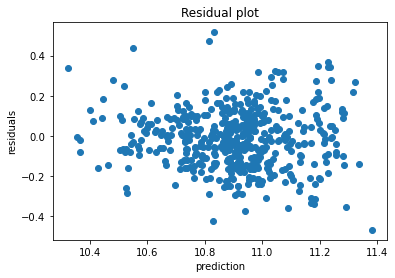

In [12]:
res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

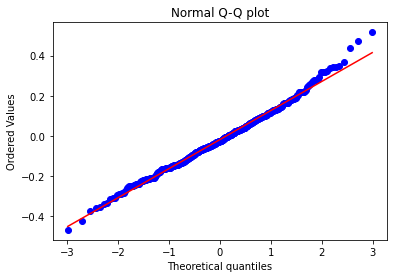

In [13]:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [14]:
#########################
## try 1/sqrt(Y)  transform of target
## as best transfrom per boxcox to fit target in normal distribution

proc_data['1_sqrt_med_inc'] = proc_data['Median_Household_Income_2019']**-0.5


In [15]:
proc_data.head()

,FIPS_code,Stabr,area_name,Area_Name,Median_Household_Income_2019,Civilian_labor_force_2019,Unemployment_rate_2019,hwy_count,city_town_counts,Metro_2013,...,log_Civilian_LF,Rural_urban_continuum_code_2013_1.0,Rural_urban_continuum_code_2013_2.0,Rural_urban_continuum_code_2013_3.0,Rural_urban_continuum_code_2013_4.0,Rural_urban_continuum_code_2013_5.0,Rural_urban_continuum_code_2013_6.0,Rural_urban_continuum_code_2013_7.0,Rural_urban_continuum_code_2013_8.0,1_sqrt_med_inc
0,01001,AL,"Autauga County, AL",Autauga County,58233.0,26172.0,2.7,6.0,4.0,1.0,...,10.172445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004144
1,01003,AL,"Baldwin County, AL",Baldwin County,59871.0,97328.0,2.7,12.0,14.0,1.0,...,11.485842,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.004087
2,01005,AL,"Barbour County, AL",Barbour County,35972.0,8537.0,3.8,11.0,6.0,0.0,...,9.052165,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.005273
3,01007,AL,"Bibb County, AL",Bibb County,47918.0,8685.0,3.1,8.0,5.0,1.0,...,9.069353,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004568
4,01009,AL,"Blount County, AL",Blount County,52902.0,25331.0,2.7,9.0,16.0,1.0,...,10.139784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004348


In [16]:
X2 = proc_data[['log_Civilian_LF','Unemployment_rate_2019', 
       'hwy_count', 'city_town_counts', 'Metro_2013',
       'Farming_2015_Update', 'Mining_2015-Update', 'Manufacturing_2015_Update',
       'Government_2015_Update', 'Recreation_2015_Update',
       'Nonspecialized_2015_Update', 'Low_Education_2015_Update',
       'Low_Employment_Cnty_2008_2012_25_64', 'Retirement_Dest_2015_Update',
       'Persistent_Poverty_2013', 'Rural_urban_continuum_code_2013_1.0',
       'Rural_urban_continuum_code_2013_2.0',
       'Rural_urban_continuum_code_2013_3.0',
       'Rural_urban_continuum_code_2013_4.0',
       'Rural_urban_continuum_code_2013_5.0',
       'Rural_urban_continuum_code_2013_6.0',
       'Rural_urban_continuum_code_2013_7.0',
       'Rural_urban_continuum_code_2013_8.0']]

y_t2 = proc_data['1_sqrt_med_inc']


In [17]:
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(X2, y_t2, test_size=0.2, random_state=42)
# same test holdout as above and previous models examined

In [18]:
# with different transformation of target

# arrays for KFold
X, y = np.array(X_train_val2), np.array(y_train_val2)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)  # same sample for folds as above
cv_lm_r2s = [] #collect the validation results R2
cv_lm_rmse = [] #collect the validation RMSE


for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    y_pred = lm.predict(X_val)
    # transformed y by 1/sqrt(y),  put RSME in orginal dollar terms
    cv_lm_rmse.append(round(np.sqrt(mean_squared_error((y_val)**-2, (y_pred)**-2)), 2))

print('Linear regression scores: ', cv_lm_r2s, '\n')

print(f'Mean CV r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}', '\n')

print(f'Linear regression RMSEs: ', cv_lm_rmse, '\n')

print(f'Mean CV RMSE:  {np.mean(cv_lm_rmse):.2f} +- {np.std(cv_lm_rmse):.2f}')

Linear regression scores:  [0.625, 0.645, 0.644, 0.617, 0.628] 

Mean CV r^2: 0.632 +- 0.011 

Linear regression RMSEs:  [9470.01, 10058.02, 9938.7, 8978.99, 8627.1] 

Mean CV RMSE:  9414.56 +- 548.02


Text(0, 0.5, 'residuals')

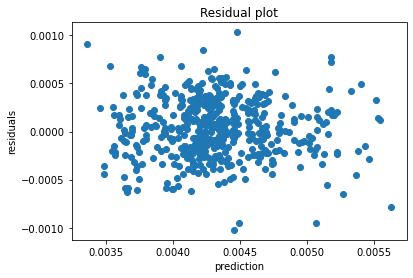

In [19]:
# last validation set
res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

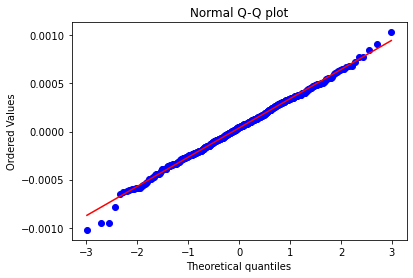

In [20]:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [21]:
# very close results of R2 and RSME with either Y transform
# with very tiny coefficients if use 1/sqrt(Y), will use log transform of target
# next will examine any improvement with polynomial or interaction terms
# still holding out test set